# QCL for classification

Reproduction of results in referenced paper

In [96]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer

We define the parameters of the simulated system

In [97]:
########  Parameter  #############
nqubit = 6 ## number of qubit
c_depth = 6 ## depth of circuit
time_step = 10 ## elapsed time of time evolution with random Hamiltonian

We generate teaching data

[array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0,

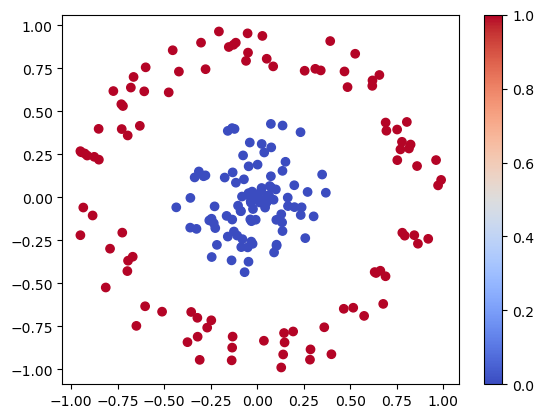

In [98]:
## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)
np.random.seed(0)

num_x_train = 100

r_min = 0.; r_max = 0.45
r_train = r_min + (r_max - r_min) * np.random.rand(num_x_train)
theta_train = 2.0 * np.pi * np.random.rand(num_x_train)

x_train1 = r_train * np.cos(theta_train)
y_train1= r_train * np.sin(theta_train)
z_train1 = [np.asarray([0,1]) for i in range(num_x_train)]

r_min = 0.75; r_max = 1.0
r_train = r_min + (r_max - r_min) * np.random.rand(num_x_train)
theta_train = 2.0 * np.pi * np.random.rand(num_x_train)

x_train2 = r_train * np.cos(theta_train)
y_train2= r_train * np.sin(theta_train)
z_train2 = [np.asarray([1,0]) for i in range(num_x_train)]

x_train = np.concatenate([x_train1, x_train2])
y_train = np.concatenate([y_train1, y_train2])
z_train = z_train1 + z_train2

train_values = [np.asarray([x_train[i], y_train[i]]) for i in range(len(x_train))]
print(z_train)

color = [z[0] for z in z_train]
plt.scatter(x_train, y_train, c=color, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()



## Prepare quantum state

We define the initial state to be $\ket{\psi} = \ket{000000}$. And we create the gate $U_{in}(\vec{x_i})$ for embedding the input value $x_i$ in the initial state $\ket{\psi}$. According to reference $[1]$ we define:
$U_{in}(\vec{x_i}) = $
with rotation gates
$\Pi_j R^Z_j(\cos^{-1}x^2_{i,j \ mod \ 2}) R^Y_j(\sin^{-1}x_{i,j \ mod \ 2})$

So input $\vec{x_i}$, is converted into: $\ket{\psi_{in}(\vec{x_i})} = U_{in}(\vec{x_i})\ket{00...0}$


In [99]:
# Initial State
state = QuantumState(nqubit) # Initial state |000000>
state.set_zero_state()

In [100]:
def U_in(x):
    U = QuantumCircuit(nqubit)

    for j in range(nqubit):
        jmod = j%2
        xij = x[jmod]
        angle_y = np.arcsin(xij)
        angle_z = np.arccos(xij**2)
        U.add_RY_gate(j, angle_y)
        U.add_RZ_gate(j, angle_z)

    return U

[-1.80444035e-01-9.34385968e-01j -1.64587321e-01+1.27134160e-02j
  5.46080506e-02-9.78275590e-03j -6.11527359e-04-9.60391883e-03j
 -1.64587321e-01+1.27134160e-02j -1.04736966e-03+2.86159732e-02j
 -6.11527359e-04-9.60391883e-03j -1.66722106e-03-8.35755599e-05j
  5.46080506e-02-9.78275590e-03j -6.11527359e-04-9.60391883e-03j
  5.27261798e-04+3.19084214e-03j  5.60300597e-04-2.80871189e-05j
 -6.11527359e-04-9.60391883e-03j -1.66722106e-03-8.35755599e-05j
  5.60300597e-04-2.80871189e-05j  6.18394883e-06-9.71177196e-05j
 -1.64587321e-01+1.27134160e-02j -1.04736966e-03+2.86159732e-02j
 -6.11527359e-04-9.60391883e-03j -1.66722106e-03-8.35755599e-05j
 -1.04736966e-03+2.86159732e-02j  4.91121482e-03+7.43564694e-04j
 -1.66722106e-03-8.35755599e-05j -4.72085331e-05+2.85692947e-04j
 -6.11527359e-04-9.60391883e-03j -1.66722106e-03-8.35755599e-05j
  5.60300597e-04-2.80871189e-05j  6.18394883e-06-9.71177196e-05j
 -1.66722106e-03-8.35755599e-05j -4.72085331e-05+2.85692947e-04j
  6.18394883e-06-9.711771

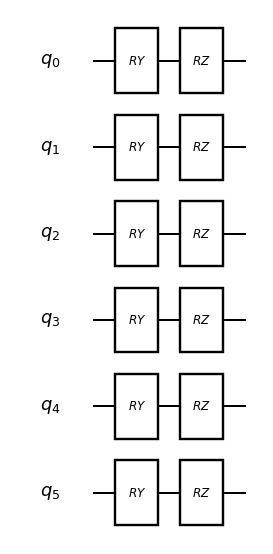

In [101]:
# Test initial state
x = train_values[10]
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

circuit_drawer(U_in(x),'mpl')

With the input value codificated into the quantum state, we construct the variational quantum circuit in the same way that we did for the one dimensional fit of $\sin(x)$

In [102]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

Using ```make_fullgate``` the hamiltonian is then calculated as a sum of X and Z gates multiplied by corresponding coefficients. 

After that, the corresponding time evolution operator is calculated as $U_{rand} = e^{-iHt}$

In [103]:
#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [104]:
# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

### 2. Create rotation gates and 3. Create $U(\theta)$

In this step, the previously calculated evolution operator $U_{rand}$ is combined with the rotation gates operator of for the $j = (1,2,...,n)$th qubit:

$U_{rot}(\theta_j^{(i)}) = R^X_j(\theta^{(i)}_{j1})R^Z_j(\theta^{(i)}_{j2})R^X_j(\theta^{(i)}_{j3})$

To create the variational quantum circuit $U(\theta)$:

$U\left(\{ \theta^{(i)}_{j} \}_{i,j} \right) = \prod\limits_{i=1}^d \left( \left( \prod\limits_{j=1}^n U_{rot}(\theta_j^{(i)}) \right) . U_{rand} \right)$
 
 
suffix $i$ is representing the layer of the quantum circuit, and $U_{rand}$ and the above rotation are repeated in $d$ layers in total. There are $3 \times n \times d$ parameters. 
The intial value of each $\theta$ is a uniform distribution of $\left[ 0,2 \pi \right]$ 
.

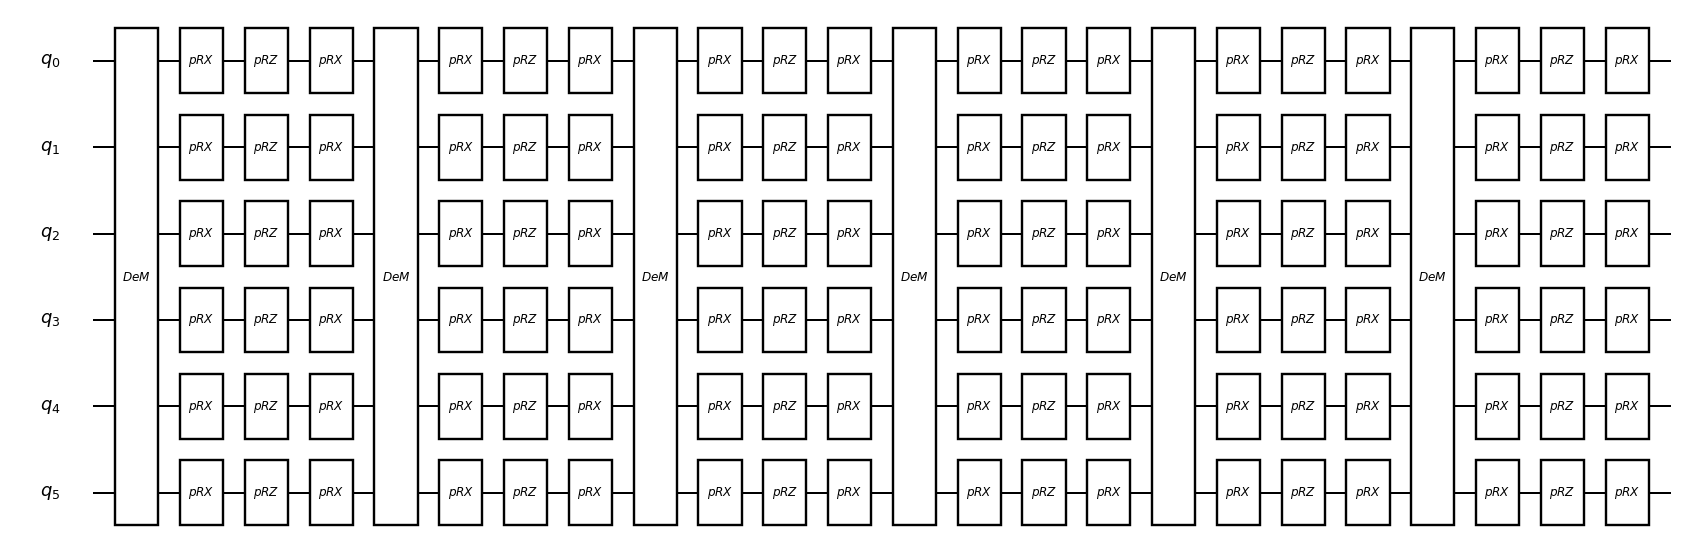

In [105]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]
circuit_drawer(U_out,'mpl')

The ```ParametricQuantumCircuit``` class from the qulacs library is used to create a quantum circuit that can have its gate parameters changed.

```U_out = ParametricQuantumCircuit(nqubit)``` creates a new ```ParametricQuantumCircuit``` with ```nqubit``` number of qubits. ```nqubit``` is not defined in the provided code, so it should be defined elsewhere in your program.

The for loop adds gates to the quantum circuit. For each iteration of the loop:

```U_out.add_gate(time_evol_gate)```: This line adds a gate to the circuit. The type of gate is not specified in the provided code, so ```time_evol_gate``` should be defined elsewhere in your program. The inner for loop adds three parametric gates (RX, RZ, and RX again) to each qubit in the circuit. The angle for each gate is randomly generated.
parameter_count = ```U_out.get_parameter_count()``` This line gets the total number of parameters in the circuit. In this case, it should be 3 * nqubit * c_depth because three parametric gates are added to each qubit for each iteration of the outer loop.

```theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]```: This line creates a list of the initial values of the parameters in the circuit. This list can be used later to change the parameters of the circuit.

Later, a function named ```set_U_out``` is defined to update parameter $\theta$ in $U(\theta)$ 

In [106]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

## Measurement

In this demostration, the output of the model will be taken from the expectation value of the Pauli Z operator of the first two qubits acting on output state $\ket{\psi_{out}}$. This values will then be transformed by the softmax function $\mathbf{F}$. For the d-dimensional vector $\mathbf{q}$, the softmax function returns the d-dimensional vector $\mathbf{F(\mathbf{q})}$, with its kth element being $\mathbf{F_k(\mathbf{q})} = e^{q_k}/\sum_i e^{q_i}$

$y(\theta,x_i)=\left<\psi_\text{out}|Z_0|\psi_\text{out}\right> $

In [107]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [108]:
# Create observable Z_0
from qulacs import Observable

def get_output(state):

    z0 = Observable(nqubit)
    z0.add_operator(1.,'Z 0') # a = 1
    z0_val = z0.get_expectation_value(state)

    z1 = Observable(nqubit)
    z1.add_operator(1.,'Z 1') # a = 1
    z1_val = z1.get_expectation_value(state)

    res = softmax(np.asarray([z0_val, z1_val]))
    
    return res

In [109]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res =get_output(state)

    return res

### Calculation of cost function

We use the cross entropy cost function

In [110]:
def cross_entropy(y_pred, y_train):
    loss = 0
    for i in range(len(y_pred)):
        for k in range(2):
            loss +=-y_train[i][k] * np.log(y_pred[i][k])

    return loss


In [111]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    predicted_output = [qcl_pred(z, U_out) for z in z_train]

    # quadratic loss
    L = cross_entropy(predicted_output, z_train)

    return L

/tmp/ipykernel_12917/3761680355.py:7: RuntimeWarning: invalid value encountered in arcsin
  angle_y = np.arcsin(xij)
/tmp/ipykernel_12917/3761680355.py:8: RuntimeWarning: invalid value encountered in arccos
  angle_z = np.arccos(xij**2)


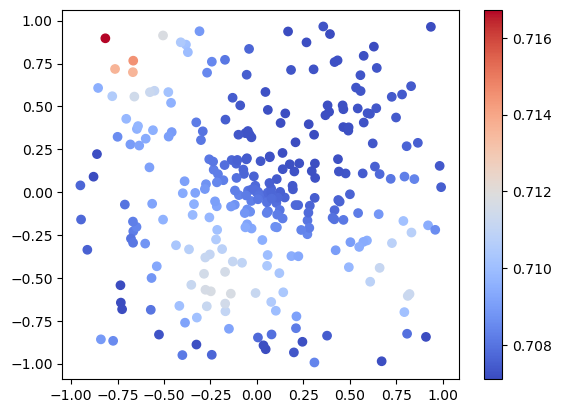

In [112]:
num_test_samples = 500

r_min = 0.; r_max = 2
r_test = r_min + (r_max - r_min) * np.random.rand(num_test_samples)
theta_test = 2.0 * np.pi * np.random.rand(num_test_samples)

x_test= r_test * np.cos(theta_test)
y_test= r_test * np.sin(theta_test)
z_test = [np.asarray([x_test[i],y_test[i]]) for i in range(num_test_samples)]

# Initial prediction
initial_prediction = [qcl_pred(z, U_out) for z in z_test]
color_initial_prediction = [np.sqrt(p[0]**2+p[1]**2) for p in initial_prediction]

plt.scatter(x_test, y_test, c=color_initial_prediction, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()

In [115]:
from scipy.optimize import minimize

result = minimize(cost_func, theta_init, method='BFGS', options={'maxiter': 50})
result.fun

/tmp/ipykernel_12917/3761680355.py:7: RuntimeWarning: invalid value encountered in arcsin
  angle_y = np.arcsin(xij)
/tmp/ipykernel_12917/3761680355.py:8: RuntimeWarning: invalid value encountered in arccos
  angle_z = np.arccos(xij**2)


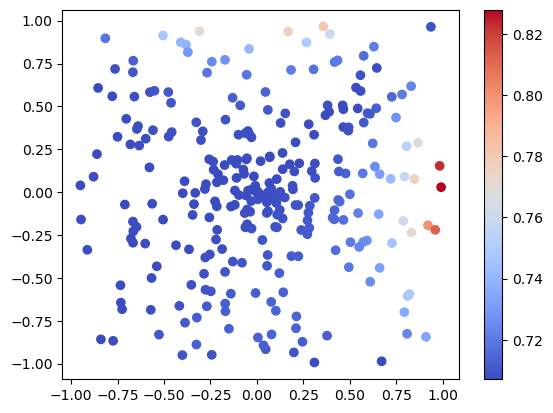

In [114]:
# Initial prediction
final_prediction = [qcl_pred(z, U_out) for z in z_test]
color_final_pred = [np.sqrt(p[0]**2+p[1]**2) for p in final_prediction]

plt.scatter(x_test, y_test, c=color_final_pred, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()